In [2]:
import os
import re
import numpy as np
from tqdm import tqdm

import tensorflow as tf
# model
from transformers import AdamW, get_linear_schedule_with_warmup
# for BERT
from transformers import BertTokenizer
from transformers import BertForSequenceClassification,  BertConfig

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [8]:
#random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
MAX_LEN = 39 # EDA에서 추출된 Max Length
DATA_IN_PATH = './nsmc'
DATA_OUT_PATH = './nsmc'

In [9]:
# 데이터 전처리 준비
DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "ratings_train.txt")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "ratings_test.txt")

train_data = pd.read_csv(DATA_TRAIN_PATH, header = 0, delimiter = '\t', quoting = 3)
train_data = train_data.dropna()
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [10]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case=False)

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [11]:
# 스페셜 토큰
print(tokenizer.all_special_tokens, "\n", tokenizer.all_special_ids)

# 토크나이저 테스트하기
kor_encode = tokenizer.encode("안녕하세요, 반갑습니다. ")
eng_encode = tokenizer.encode("Hello world")

kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
print(eng_encode)
print(kor_decode)
print(eng_decode)

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]'] 
 [100, 102, 0, 101, 103]
[101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 119, 102]
[101, 31178, 11356, 102]
[CLS] 안녕하세요, 반갑습니다. [SEP]
[CLS] Hello world [SEP]


In [13]:
# Bert Tokenizer
# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.
        
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

In [14]:
# train_data = train_data[:1000] # for test

input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

for train_sent, train_label in tqdm(zip(train_data["document"], train_data["label"]), total=len(train_data)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label)

    except Exception as e:
        print(e)
        print(train_sent)
        pass

train_movie_input_ids = np.array(input_ids, dtype=int)
train_movie_attention_masks = np.array(attention_masks, dtype=int)
train_movie_type_ids = np.array(token_type_ids, dtype=int)
train_movie_inputs = (train_movie_input_ids, train_movie_attention_masks, train_movie_type_ids)

train_data_labels = np.asarray(train_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("# sents: {}, # labels: {}".format(len(train_movie_input_ids), len(train_data_labels)))

  0%|          | 0/149995 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/DATA/jklee/miniconda3/envs/NLP/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2226: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 149995/149995 [00:45

# sents: 149995, # labels: 149995


In [18]:
# 최대 길이: 39
input_id = train_movie_input_ids[1]
attention_mask = train_movie_attention_masks[1]
token_type_id = train_movie_type_ids[1]

# print(input_id)
# print(attention_mask)
print(token_type_id)
# print(tokenizer.decode(input_id))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


In [17]:
from transformers import TFBertModel

class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

        return logits

cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=2)

Downloading:   0%|          | 0.00/1.01G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [19]:
# 학습 준비하기
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [20]:
model_name = "tf2_bert_naver_movie"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = cls_model.fit(train_movie_inputs, train_data_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

#steps_for_epoch

print(history.history)

./nsmc/tf2_bert_naver_movie -- Folder create complete 

Epoch 1/3
3750/3750 [==============================] - ETA: 0s - loss: 0.4116 - accuracy: 0.8064
Epoch 00001: val_accuracy improved from -inf to 0.85070, saving model to ./nsmc/tf2_bert_naver_movie/weights.h5
3750/3750 [==============================] - 817s 218ms/step - loss: 0.4116 - accuracy: 0.8064 - val_loss: 0.3469 - val_accuracy: 0.8507
Epoch 2/3
3750/3750 [==============================] - ETA: 0s - loss: 0.3177 - accuracy: 0.8612
Epoch 00002: val_accuracy improved from 0.85070 to 0.86350, saving model to ./nsmc/tf2_bert_naver_movie/weights.h5
3750/3750 [==============================] - 794s 212ms/step - loss: 0.3177 - accuracy: 0.8612 - val_loss: 0.3315 - val_accuracy: 0.8635
Epoch 3/3
3750/3750 [==============================] - ETA: 0s - loss: 0.2647 - accuracy: 0.8895
Epoch 00003: val_accuracy did not improve from 0.86350
3750/3750 [==============================] - 779s 208ms/step - loss: 0.2647 - accuracy: 0.8895 - 

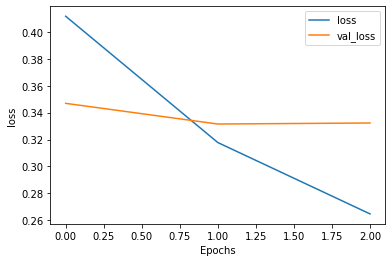

In [21]:
plot_graphs(history, 'loss')

In [22]:
test_data = pd.read_csv(DATA_TEST_PATH, header = 0, delimiter = '\t', quoting = 3)
test_data = test_data.dropna()
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [23]:
input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []

for test_sent, test_label in tqdm(zip(test_data["document"], test_data["label"])):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(test_sent, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        test_data_labels.append(test_label)
    except Exception as e:
        print(e)
        print(test_sent)
        pass

test_movie_input_ids = np.array(input_ids, dtype=int)
test_movie_attention_masks = np.array(attention_masks, dtype=int)
test_movie_type_ids = np.array(token_type_ids, dtype=int)
test_movie_inputs = (test_movie_input_ids, test_movie_attention_masks, test_movie_type_ids)

test_data_labels = np.asarray(test_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("num sents, labels {}, {}".format(len(test_movie_input_ids), len(test_data_labels)))

0it [00:00, ?it/s]/DATA/jklee/miniconda3/envs/NLP/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2226: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
49997it [00:15, 3324.12it/s]


num sents, labels 49997, 49997


In [24]:
results = cls_model.evaluate(test_movie_inputs, test_data_labels, batch_size=1024)
print("test loss, test acc: ", results)

49/49 [==============================] - 60s 1s/step - loss: 0.3357 - accuracy: 0.8589
test loss, test acc:  [0.3357372581958771, 0.8589315414428711]
